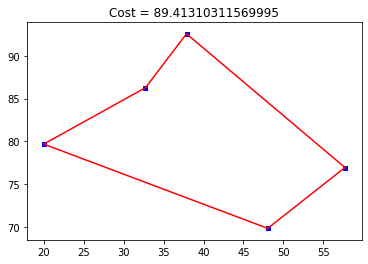

[1, 5, 3, 4, 2] 89.41310311569995


In [11]:
###Example of a Genetic Algirthm for TSP - RECOMMEND YOU ONLY CHANGE THE PARTS NEAR END (HIGHLIGHTED)

import sys, math, random, heapq
import matplotlib.pyplot as plt
from itertools import chain

if sys.version_info < (3, 0):
   sys.exit("""Sorry, requires Python 3.x, not Python 2.x.""")

class Graph:

    def __init__(self, vertices):
        self.vertices = vertices
        self.n = len(vertices)

    def x(self, v):
        return self.vertices[v][0]

    def y(self, v):
        return self.vertices[v][1]

    # Lookup table for distances
    _d_lookup = {}

    def d(self, u, v):
        """Euclidean Metric d_2((x1, y1), (x2, y2))"""

        # Check if the distance was computed before
        if (u, v) in self._d_lookup:
            return self._d_lookup[(u, v)]

        # Otherwise compute it
        _distance = math.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2)

        # Add to dictionary
        self._d_lookup[(u, v)], self._d_lookup[(v, u)] = _distance, _distance
        return _distance

    def plot(self, tour=None):
        """Plots the cities and superimposes given tour"""
        if tour is None:
            tour = Tour(self, [])

        _vertices = [self.vertices[0]]

        for i in tour.vertices:
            _vertices.append(self.vertices[i])

        _vertices.append(self.vertices[0])

        plt.title("Cost = " + str(tour.cost()))
        plt.plot(*zip(*_vertices), '-r')
        plt.scatter(*zip(*self.vertices), c="b", s=10, marker="s")
        plt.show()


##### Calculates the distance of a given (full) path
class Tour:

    def __init__(self, g, vertices = None):
        """Generate random tour in given graph g"""

        self.g = g

        if vertices is None:
            self.vertices = list(range(1, g.n))
            random.shuffle(self.vertices)
        else:
            self.vertices = vertices

        self.__cost = None

    def cost(self):
        """Return total edge-cost of tour"""

        if self.__cost is None:
            self.__cost = 0
            for i, j in zip([0] + self.vertices, self.vertices + [0]):
                self.__cost += self.g.d(self.g.vertices[i], self.g.vertices[j])
        return self.__cost

##### Main GA parameters (Probability of creating each type of child)
class GeneticAlgorithm:

    def __init__(self, g, population_size, k=5, elite_mating_rate=0.5,
                 mutation_rate=0.015, mutation_swap_rate=0.2):   #Probability of each type of child being created
        """Initialises algorithm parameters"""

        self.g = g
        
        self.population = []
        for _ in range(population_size):
            self.population.append(Tour(g))

        self.population_size = population_size
        self.k = k
        self.elite_mating_rate = elite_mating_rate
        self.mutation_rate = mutation_rate
        self.mutation_swap_rate = mutation_swap_rate

##### Crossover - as described in Teaching Material (Week 10 = AI)
    def crossover(self, mum, dad):
        """Implements ordered crossover"""

        size = len(mum.vertices)

        # Choose random start/end position for crossover
        alice, bob = [-1] * size, [-1] * size
        start, end = sorted([random.randrange(size) for _ in range(2)])

        # Replicate mum's sequence for alice, dad's sequence for bob
        for i in range(start, end + 1):
            alice[i] = mum.vertices[i]
            bob[i] = dad.vertices[i]

        # Fill the remaining position with the other parents' entries
        current_dad_position, current_mum_position = 0, 0

        for i in chain(range(start), range(end + 1, size)):

            while dad.vertices[current_dad_position] in alice:
                current_dad_position += 1

            while mum.vertices[current_mum_position] in bob:
                current_mum_position += 1

            alice[i] = dad.vertices[current_dad_position]
            bob[i] = mum.vertices[current_mum_position]

        # Return twins
        return Tour(self.g, alice), Tour(self.g, bob)

##### Mutation - as done in TSP_HillClimb.py and described in Teaching Material (Week 9)
    def mutate(self, tour):
        """Randomly swaps pairs of cities in a given tour according to mutation rate"""

        # Decide whether to mutate
        if random.random() < self.mutation_rate:

            # For each vertex
            for i in range(len(tour.vertices)):

                # Randomly decide whether to swap
                if random.random() < self.mutation_swap_rate:

                    # Randomly choose other city position
                    j = random.randrange(len(tour.vertices))

                    # Swap
                    tour.vertices[i], tour.vertices[j] = tour.vertices[j], tour.vertices[i]

##### Selects the fittest parents
    def select_parent(self, k):
        """Implements k-tournament selection to choose parents"""
        tournament = random.sample(self.population, k)
        return max(tournament, key=lambda t: t.cost())

##### Checks fitness of parents/child and creates new population
    def evolve(self):
        """Executes one iteration of the genetic algorithm to obtain a new generation"""

        new_population = []

        for _ in range(self.population_size):

            # K-tournament for parents
            mum, dad = self.select_parent(self.k), self.select_parent(self.k)
            alice, bob = self.crossover(mum, dad)

            # Mate in an elite fashion according to the elitism_rate
            if random.random() < self.elite_mating_rate:
                if alice.cost() < mum.cost() or alice.cost() < dad.cost():
                    new_population.append(alice)
                if bob.cost() < mum.cost() or bob.cost() < dad.cost():
                    new_population.append(bob)

            else:
                self.mutate(alice)
                self.mutate(bob)
                new_population += [alice, bob]

        # Add new population to old
        self.population += new_population

        # Retain fittest
        self.population = heapq.nsmallest(self.population_size, self.population, key=lambda t: t.cost())

###########################################################################
##### IMPORTANT ##### number of generations

    def run(self, iterations=200):  #Number of Generations: more = better, but takes longer
        for _ in range(iterations):
            self.evolve()

    def best(self):
        return max(self.population, key=lambda t: t.cost())

###########################################################################
##### IMPORTANT ##### The data for the Question

#Practical 9, Question 5
g = Graph([
(48.039399290203,69.8632165852765),
(57.7102187574938,76.9610339716859),
(32.7323075124292,86.2753678010589),
(37.8697820230032,92.5591094904637),
(19.9906676704456,79.6926263050003),
])


###########################################################################
##### IMPORTANT ##### population size

ga = GeneticAlgorithm(g, 100)    #Inputs (graph co-ordinates, POPULATION SIZE)  more = better, but takes longer
ga.run()


########## Output
best_tour = ga.best()
g.plot(best_tour)   #Plots the path on a graph

best_path = best_tour.vertices
size = len (g.vertices)
for i in range(size-1):
    best_path[i]=best_path[i]+1   #Must +1 to nodes to chnage numbering from (0,n-1) to (1,n)
best_path.insert(0,1)   #Adds start node to the list
print(best_path,best_tour._Tour__cost)   #Prints the best path and distance
